# Will the S&P 500 go above index 3800 by March 1st 2021?


So most of the time when I make predictions, I'll spend a couple of minutes trying to come up with relevant [reference classes](https://en.wikipedia.org/wiki/Reference_class_forecasting). If it feels tractable, I'll try to [guestimate](https://www.getguesstimate.com/users/7831) answers to the sub-questions. But the following question: "By date_X, will the S&P 500 fall below Index_Y?" was quite hard to answer this way.  Since it's asked every month on [Almanis](https://www.almanisprivate.com/almanis-app), I thought this could be a quite handy exercise in working with timeseries. Feel free to use the notebook for your own predictions. [Here is a link](https://raw.githubusercontent.com/sonofhypnos/projects/master/_notebooks/%5EGSPC.csv) to the S&P 500 CSV-file which I downloaded from [Yahoo Finance](https://finance.yahoo.com/quote/%5EGSPC/history?period1=-1325635200&period2=1611964800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true).

I assumed the SP 500 to be a (biased) random walk. This might not be true, but if I could do any better I wouldn't be betting "play-money" on Almanis. I would be making a fortune on Wallstreet instead.
For this example, I will ask the question: "Will the S&P 500 go above 3800 by March 1st, 2021?"

To answer whether the S&P 500 will exceed a certain index, I looked at the difference between the current index (3,714.7) and the index that we want to know the [probability of exceedance](https://en.wikipedia.org/wiki/Frequency_of_exceedance) for (3800). I computed this probability by looking at the frequency at which the index has moved by that much in the past.[^1][^2]

[^1]: To be precise, I computed the size of the gap between the current index and the boundary index (3900) as a percentage of the absolute index. I then looked at how often such a big gap had been exceeded in the past in the same number of days.


[^2]: I considered learning how to do fancy things like volatility forecasting. But when I looked into it, it didn’t feel super exciting. And doing it just for the 8$ dollars I’d be winning on Almanis would be working for less than minimum wage, so I didn’t do it.


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.graphics as stg #we are going to use this later on to check our timeseries for autocorrelation
import statsmodels.api as sm
%matplotlib inline

df = pd.read_csv("https://raw.githubusercontent.com/sonofhypnos/projects/master/_notebooks/%5EGSPC.csv")



In [10]:
days_ahead = 30 # the number of days that the S&P has to stay within the boundary
boundary = 3800


So before we can answer our initial question, we need to take a look at our data.

In [11]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0


As you can see this dataset goes back until 1927. Another thing to notice here is that we only have data for the S&P 500 on business days. Since this is only supposed to be a rough forecast, I am going to ignore this fact and just pretend that the difference between Fridays and Mondays will be the same as between Tuesdays and Wednesdays. But we will still have to keep this fact in mind, so that our forecast also only includes workdays.

In [12]:
sp = df.Close
sp.index = pd.to_datetime(df.Date)

In [13]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...,...,...
23376,2021-01-25,3851.679932,3859.229980,3797.159912,3855.360107,3855.360107,6955860000
23377,2021-01-26,3862.959961,3870.899902,3847.780029,3849.620117,3849.620117,6029090000
23378,2021-01-27,3836.830078,3836.830078,3732.479980,3750.770020,3750.770020,9878040000
23379,2021-01-28,3755.750000,3830.500000,3755.750000,3787.379883,3787.379883,6937960000


In [14]:
sp.head()

Date
1927-12-30    17.660000
1928-01-03    17.760000
1928-01-04    17.719999
1928-01-05    17.549999
1928-01-06    17.660000
Name: Close, dtype: float64

Let's take a first look at our timeseries

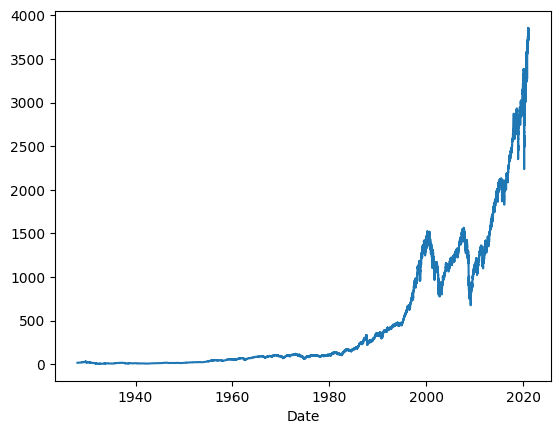

In [15]:
sns.lineplot(x=sp.index, y=sp.values);

As you can see the graph is growing exponentially. This is even more clear on a log scale:

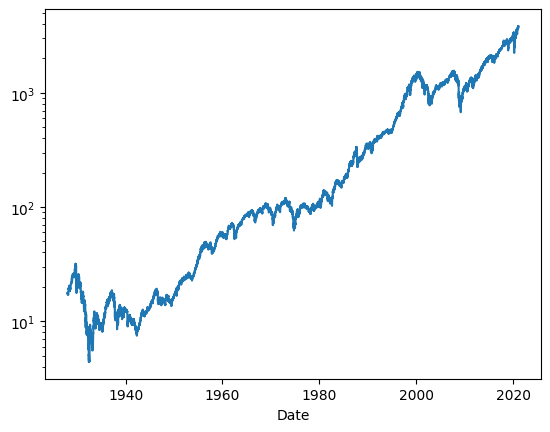

In [16]:
sns.lineplot(x=sp.index, y=sp.values)
plt.yscale("log")

We now take a closer look at the correlation in our graph. If this was a (biased) random walk, then there shouldn't be any (auto-)correlation between price changes{% fn 3 %}. 
This is indeed what we see:

[^3]: There actually is a positive correlation in the movement between days, but it is not exploitable and it is a better strategy to just hold your funds. If you want to learn more about time-series analysis, I can recommend [datacamps course on time-series](https://www.datacamp.com/tracks/time-series-with-python). There are also great [free resources](https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/) out there.

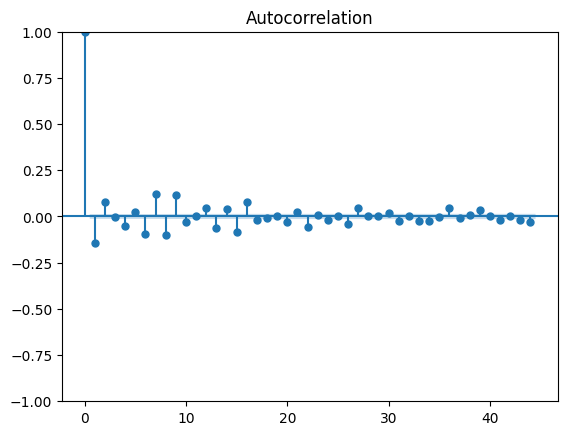

In [17]:
pricechange = sp - sp.shift()
stg.tsaplots.plot_acf(pricechange[1:])
plt.show()

The following function computes the relative difference between different days in the past.

In [18]:
def relative_shift_n(ts, n):
    ts_shift = []
    for i in range(1,n+1):
        ts_shift.append((ts - ts.shift(periods=i))/ts)
    return ts_shift

Now we compute the number of workdays ahead for our forecast

In [19]:
current_weekday = sp[-1:].index.weekday[0] + 1
n=0
for i in range(days_ahead):
    if (current_weekday % 7) < 5:
        n += 1
    current_weekday += 1
print("workdays ahead:", n)

workdays ahead: 20


In [20]:
sp_shift = relative_shift_n(sp, n)
shift_index = [str(x) for x in range(1,n+1)]
sp_shift = pd.DataFrame.from_dict(dict(zip(shift_index,sp_shift)))
sp_shift = sp_shift[n:] #removing NaN entries

`sp_shift` is an array of price-changes for different intervalls. The title of each column corresponds to the number of days between which the price change was computed. 

In [21]:
sp_shift

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Date,,,,,,,,,,,,,,,,,,,,
1928-01-30,-0.011435,-0.008005,-0.001715,-0.012579,-0.008576,0.000572,0.006289,0.013150,0.010863,0.011435,-0.005146,0.001144,0.008005,0.006861,-0.000572,-0.009720,-0.003430,-0.013150,-0.015437,-0.009720
1928-01-31,0.004553,-0.006830,-0.003415,0.002846,-0.007968,-0.003984,0.005122,0.010814,0.017644,0.015367,0.015936,-0.000569,0.005692,0.012521,0.011383,0.003984,-0.005122,0.001138,-0.008537,-0.010814
1928-02-01,-0.002282,0.002282,-0.009127,-0.005704,0.000571,-0.010268,-0.006275,0.002852,0.008557,0.015402,0.013120,0.013691,-0.002852,0.003423,0.010268,0.009127,0.001711,-0.007416,-0.001141,-0.010838
1928-02-02,0.005672,0.003403,0.007941,-0.003403,0.000000,0.006239,-0.004538,-0.000567,0.008508,0.014180,0.020987,0.018718,0.019285,0.002836,0.009075,0.015882,0.014747,0.007374,-0.001702,0.004538
1928-02-03,-0.013218,-0.007471,-0.009770,-0.005172,-0.016667,-0.013218,-0.006897,-0.017816,-0.013793,-0.004598,0.001149,0.008046,0.005747,0.006322,-0.010345,-0.004023,0.002874,0.001724,-0.005747,-0.014943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,0.003603,0.000594,0.000910,0.014642,0.022595,0.015516,0.011807,0.014051,0.014460,0.007958,0.013376,0.027811,0.033330,0.040129,0.025754,0.031987,0.033284,0.031125,0.039503,0.042888
2021-01-26,-0.001491,0.002117,-0.000896,-0.000579,0.013173,0.021137,0.014048,0.010333,0.012581,0.012991,0.006479,0.011905,0.026361,0.031889,0.038697,0.024301,0.030543,0.031842,0.029681,0.038071
2021-01-27,-0.026355,-0.027885,-0.024182,-0.027274,-0.026949,-0.012835,-0.004660,-0.011936,-0.015749,-0.013443,-0.013021,-0.019705,-0.014136,0.000701,0.006375,0.013363,-0.001413,0.004994,0.006327,0.004108


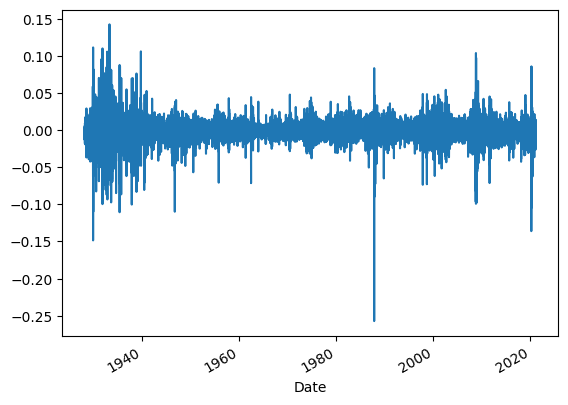

In [22]:
sp_shift["1"].plot();

The following function finally computes the probability of this happening.

probability of going above boundary:
0.5810110868541586


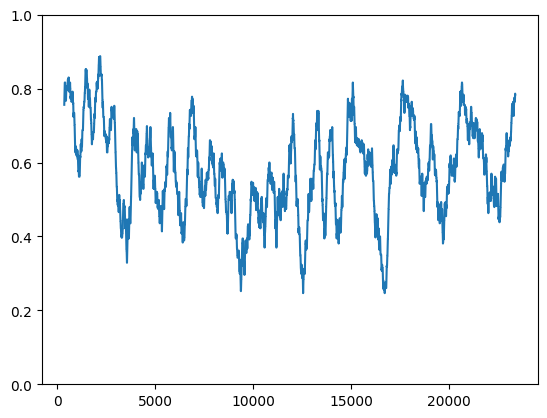

In [26]:
sp_forecast = float(sp[-1:].iloc[0]) + sp_shift * float(sp[-1:].iloc[0])

beyond_boundary = []
#change beyond boundary list based on whether our boundry is 
#above or below the current index of the S&P 500
if float(sp[-1:].iloc[0]) < boundary:
    print("probability of going above boundary:")
    for i in range(len(sp_forecast)):
        beyond_boundary.append(any(sp_forecast.iloc[i] > boundary)) 
else:
    print("probability of going below boundary:")
    for i in range(len(sp_forecast)):
        beyond_boundary.append(any(sp_forecast.iloc[i] < boundary))

beyond_boundary = pd.Series(beyond_boundary)

print(beyond_boundary.mean())

beyond_boundary.rolling(window=365).mean().plot()
axes = plt.gca()
axes.set_ylim([0,1])
plt.show()

As we can see, there is some variation. But the rolling average stays in the 40-80% range most of the time.[^4] So if the current forecast at Almanis would be at 30%, I could place a relatively confident bet on "YES". I can do this because I assume the other Almanis participants value their time enough to not make an even more sophisticated model. I also don't expect them to have information about the direction the market is going. If they did, they could make a fortune shorting or buying the S&P 500 instead.

[^4]: This actually makes me more confident that this is the right way to model this. I had been trying to use the absolute difference on just more recent data, but when looking at the last graph it had been really obvious that the gaps were growing larger and the relative difference might be more appropriate